In [222]:
#import urllib
import numpy as np
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [223]:
csv_df = pd.read_csv('/content/SentimentAnalysis.csv',low_memory=False)

# **Data Set Defination**:
From the data frame information we can see it has 21 columns and the 34660 rows

But each row is not filled with all the columns so we need to perform some column removal and perform data exploration

We can figure out the required columns and drop the rest

Also we need to perform renaming of the remaining columns for better readability

In [ ]:
csv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

# **Dropping Few Columns**
Columns like review.id, provinance, did_purchase, city because the data related to them is low

Also removing columns like user name, source, keys considering they are don't effect the prediction

Also columns related to date are not of much significane for us because we are assuming the weight of of the rating is similar irrespective of time

Also dropping do recommend because here in sentiment analysis we are not considering for each product individually infact we are performing thinking all products are same

As the count of removed columns is more so instead selecting rest of the columns


In [ ]:
selectColumns = csv_df[["id", "name","asins","brand","categories","reviews.numHelpful","reviews.rating","reviews.text","reviews.title"]]

# **Data Exploration**  
Based on the checking sample data below we can assume the first 3 columns are similar if the assumption is correct we can select one among those 3.

The Brand Column is all the times amazon if so then we can drop it.
The Recommend Column is mostly true based on the output we can perform some actions 

Number of Helpful looks like mostly 0.0 if it is true then we need to drop it completely because our data set is not very huge that we can just ignore not helpful once.

Rating and text are mandatory columns.

Title also we can drop because its just one word which will give a strong relation to the rating but if we use it we don't perform much analysis which may easily give best performance.Also most of them are using product name which can be know from first 3 columns, this can easily provide the rating because 


In [ ]:
selectColumns[:5]

,id,name,asins,brand,categories,reviews.numHelpful,reviews.rating,reviews.text,reviews.title
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.0,5.0,This product so far has not disappointed. My c...,Kindle
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.0,5.0,great for beginner or experienced person. Boug...,very fast
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.0,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",0.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids


Checking if first 3 columns are same

In [ ]:
#removing nulls from the first 3 columns
removeNA=selectColumns.dropna(subset=['id','name','asins'])

In [ ]:
#checking unique value count
print(len(removeNA['id'].value_counts()))
print(len(removeNA['name'].value_counts()))
print(len(removeNA['asins'].value_counts()))

29
48
29


From this below result can confirm our hypothesis is but correct, the first and 3rd column are same because the unique count together and individually is same

We can select 3rd from 1st and 3rd as it is more readable

But we can remove the name and category column also because it is also related to product details and those count is more than 'asins' column. As our data set is not very huge so better to have more values under a product for better analysis


In [ ]:
#checking unique value count for id, asin together
removeNA.groupby(by=['id','asins']).ngroups

29

Checking for Brand column if it entirely amazon which is true based on below output

In [ ]:
print(len(removeNA['brand'].value_counts()))

1


 **Plotting number of Helpful reviews and getting details of ratio of ratings**

Using Histogram for plotting
From below we find that number of useful review rating is almost zero for evey review so we need to drop it.

Ratings are found more inclined to 4 and 5. So while we develop model lets consider 3,2,1 as negative label so that log likely hood is not very positive initally

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8b8c91850>,
      dtype=object)

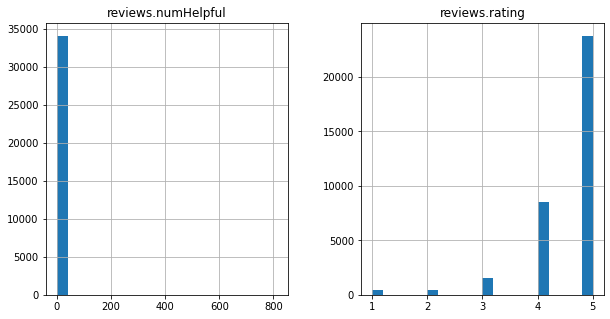

In [ ]:
selectColumns.hist(bins=20, figsize=(10,5))

So now after some analysis we can drop the rest of not required columns which are id, name, brand, number of Helpful, Title

In [ ]:
finalColumns = selectColumns[["asins","reviews.rating","reviews.text"]]

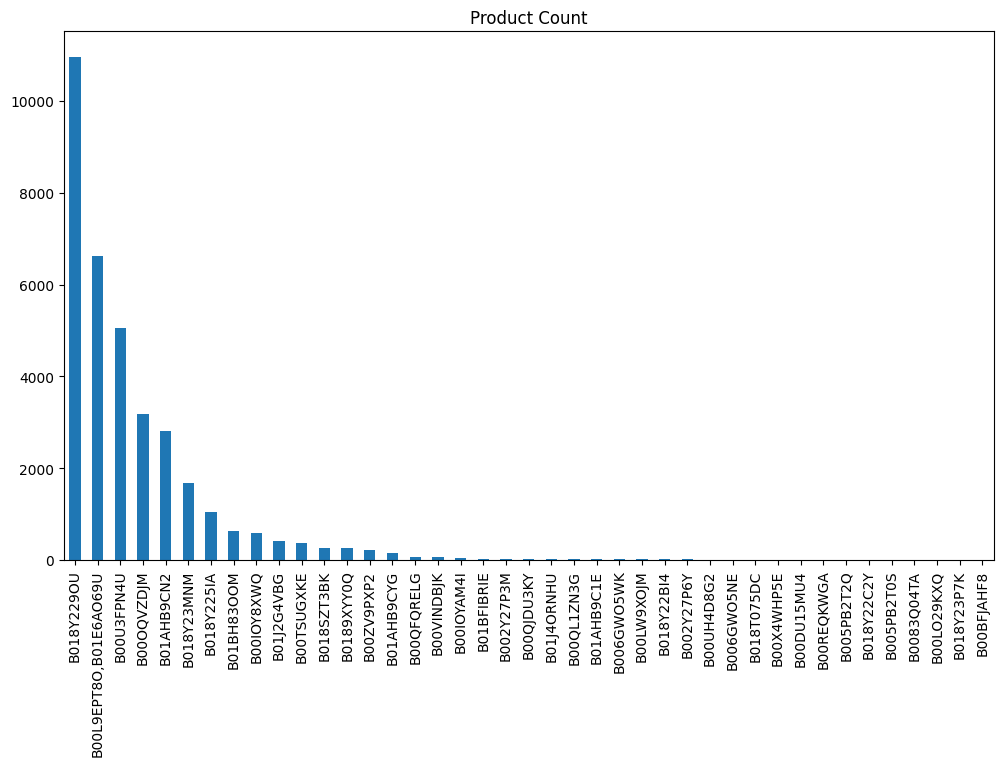

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 7), dpi=100)
asin = finalColumns["asins"].value_counts().index
finalColumns["asins"].value_counts().plot(title="Product Count",kind="bar")
plt.show()

From above we unerstand that there are only few products with correct data

## **Sentiment Analysis Model**
Based on our data analysis we perform transform like renaming columns, choosing required columns, dropping the nulls for ratings and reviews column.

Then as part of Preprocessing where we are applying tokenization, stop word removal, stemmer function.

Then we apply all these preprocessing on the reviews.

As per our data analysis we found that 5 and 4 ratings are more, so we group 3,2,1 as negative and only 4,5 as positive to maintain the likely hood for a given review to be not more positive intended.

In our data we don't want equal positive and negative reviews because based on the exploratory data and real world data sentiments mostly tend positive so if likely hood is 0 then result won't be very productive
Then we divid train and test data and use few models


In [224]:
#csv_df is our data frame with file data

rename=csv_df.rename(columns={'reviews.rating': 'Ratings', 'reviews.text': 'Reviews'})

In [251]:
requiredColumns=rename_df[['Ratings','Reviews']]

In [232]:
dropNan_df = requiredColumns.dropna(subset=['Ratings','Reviews'])

dropNan_df['Ratings']= dropNan_df['Ratings'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Pre Processing**

In [226]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Function for tokenizing the review

In [228]:
def tokenize_review(review):
  review_tokens=word_tokenize(review)
  return review_tokens


Removing Stop words and punctuations

In [229]:
nltk.download('stopwords')


stopwords_english = stopwords.words('english')

punctuations = string.punctuation

def remove_stopwords_punctuations(review_tokens):
    
    review_clean = []
    
    for word in review_tokens:
        if (word not in stopwords_english and word not in punctuations):
            review_clean.append(word)
            
    return review_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stemming the words for more relativity in data

In [230]:
stemmer = PorterStemmer()

def get_stem(review_clean):
    
    reviews_stem = []
    
    for word in review_clean:
        stem_word = stemmer.stem(word)
        reviews_stem.append(stem_word)
        
    return reviews_stem

Combing all the preprocessing steps

In [231]:
def process_review(review):
    
    review_tokens = tokenize_review(review)
    review_clean = remove_stopwords_punctuations(review_tokens)
    reviews_stem = get_stem(review_clean)
    
    return reviews_stem

Applying Preprocessing on the review Column

In [233]:
dropNan_df['Reviews'].apply(process_review)

0        [thi, product, far, disappoint, My, children, ...
1        [great, beginn, experienc, person, bought, gif...
2        [inexpens, tablet, use, learn, step, nabi, He,...
3        [I, 've, fire, HD, 8, two, week, I, love, thi,...
4        [I, bought, grand, daughter, come, visit, I, s...
                               ...                        
34655    [thi, appreci, faster, 1.8, higher, amp, charg...
34656    [amazon, includ, charger, kindl, the, fact, 'r...
34657    [love, kindl, fire, I, realli, disappoint, kin...
34658    [I, surpris, find, come, type, charg, cord, I,...
34659    [spite, fact, noth, good, thing, say, amazon, ...
Name: Reviews, Length: 34626, dtype: object

Creating tagging function

In [234]:
def tagging(rating):
  if rating<4 and rating>0:
    return 0
  if rating==5 or rating==4:
    return 1

Applying tagging to ratings

In [240]:
dropNan_df['Ratings']=dropNan_df['Ratings'].apply(tagging)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Creating list so that we can pass to models

In [241]:
X_reviews = dropNan_df['Reviews'].to_numpy().tolist()
X_rating=dropNan_df['Ratings']

Train and Test Data Preperation

In [242]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_reviews, X_rating, test_size=0.20)

# **Applying Linear SVC**

Here have used linear SVC model because
Before applying linear SVC have used count vectorizebecause we need the frequency of the words and have applied n_gram_range parameter as it improved performance
Then applied tfidf transform so that we get log values which will help in identifying the words which are more relevant by applying log to them

In [243]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

svc_l = Pipeline([("cv", CountVectorizer(ngram_range=(1,1))),("tf-idf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())]) 
svc_l.fit(X_train, Y_train)

pred = svc_l.predict(X_test)
np.mean(pred == Y_test)

0.938492636442391

# **Grid Search CV**
After SVC Linear Model we found a good performance so we tried to fine tune it by applying gridsearch on top of it.
here we used 2 parameter one for Count Vectorization and other for tfidf.
For Count Vectorization we again performed ngramrange and for tfidf applied useidf.

In [245]:
from sklearn.model_selection import GridSearchCV
param = {'cv__ngram_range': [(1, 1), (1, 2)],    
             'tf-idf__use_idf': (True, False), 
             } 
svc_g = GridSearchCV(svc_l, param, n_jobs=-1)
svc_g = svc_g.fit(X_train, Y_train)

pred_g=svc_g.predict(X_test)
np.mean(pred_g==Y_test)

0.9423909904706902

# **Other BaseLine Models Performance**

Have Used Multinomial Naive Base and Logistic regression models but the performance is better with SVC

In [246]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
nbm = Pipeline([("cv", CountVectorizer(ngram_range=(1,1))), ("tf-idf", TfidfTransformer()), ("multiNB", MultinomialNB())])
nbm.fit(X_train, Y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('tf-idf', TfidfTransformer()),
                ('multiNB', MultinomialNB())])

In [247]:
prednbm = nbm.predict(X_test)
np.mean(prednbm == Y_test)

0.9311290788333815

In [248]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
lrpipe = Pipeline([("cv", CountVectorizer()), ("tf-idf", TfidfTransformer()), ("lr", LogisticRegression())])
lrpipe.fit(X_train, Y_train)


predlr = lrpipe.predict(X_test)
np.mean(predlr == Y_test)

0.9371931850996246